## composition analyses - preview

In [34]:
import scanpy as sc
import numpy as np
import pandas as pd
import os, sys, string

sc.set_figure_params(vector_friendly=False, fontsize=18)

import pandas as pd
import numpy as np

import anndata

from scipy.io import mmwrite

import matplotlib.pyplot as plt
from collections import Counter

from typing import Tuple, Union, List, Dict, Callable
import os
import gzip
import shutil
import inspect
import h5py

from matplotlib.pyplot import rc_context

import matplotlib.pyplot as plt
%matplotlib inline

import warnings

from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

warnings.filterwarnings("ignore")

In [2]:
def makedirs(dirpath):
    if not os.path.exists(dirpath):
        os.system("mkdir "+ dirpath)

In [3]:
home      = "/Users/shayat/Documents/Aachen/projects/training_gcb2023/"
datahome  = home+ "data/"
resulthome= home+ "results/"

In [4]:
makedirs(home)
makedirs(datahome)
makedirs(resulthome)

In [5]:
filename = "snRNA-seq-submission_training_scleaned_r1_2023.h5ad"

## READ

In [6]:
print(filename)

snRNA-seq-submission_training_scleaned_r1_2023.h5ad


In [7]:
adata = sc.read_h5ad(datahome+filename)

In [8]:
adata

AnnData object with n_obs × n_vars = 38825 × 27592
    obs: 'sample', 'n_counts', 'n_genes', 'percent_mito', 'doublet_score', 'dissociation_score', 'cell_type_original', 'patient_region_id', 'patient', 'patient_group', 'major_labl', 'final_cluster', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'scrublet', 'leiden0.1', 'leiden0.3', 'leiden0.5', 'leiden0.7'
    var: 'feature_biotype', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_original_colors', 'major_labl_colors', 'rank_genes_groups0.7', 'sample_colors'
    obsm: 'X_harmony', 'X_pca', 'X_pca_harmony', 'X_umap'

In [9]:
# make a copy
tmp_copy_adata = adata.copy()

sc.pp.normalize_total(tmp_copy_adata)
sc.pp.log1p(tmp_copy_adata)

In [10]:
sc.pp.scale(tmp_copy_adata, max_value=10)

In [11]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [12]:
adata

AnnData object with n_obs × n_vars = 38825 × 27592
    obs: 'sample', 'n_counts', 'n_genes', 'percent_mito', 'doublet_score', 'dissociation_score', 'cell_type_original', 'patient_region_id', 'patient', 'patient_group', 'major_labl', 'final_cluster', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'scrublet', 'leiden0.1', 'leiden0.3', 'leiden0.5', 'leiden0.7'
    var: 'feature_biotype', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_original_colors', 'major_labl_colors', 'rank_genes_groups0.7', 'sample_colors'
    obsm: 'X_harmony', 'X_pca', 'X_pca_harmony', 'X_umap'

In [13]:
# Check to make sure it's still counts
adata[:,'NEAT1'].X.todense()

matrix([[103.],
        [  2.],
        [ 20.],
        ...,
        [  5.],
        [  4.],
        [  5.]], dtype=float32)

In [15]:
cluster_key = 'cell_type_original'

In [16]:
adata.obs[cluster_key].drop_duplicates().values.tolist()

['Adipocyte',
 'Cardiomyocyte',
 'Cycling cells',
 'Endothelial',
 'Fibroblast',
 'Lymphoid',
 'Mast',
 'Myeloid',
 'Neuronal',
 'Pericyte',
 'vSMCs']

In [17]:
adata.obs.head()

,sample,n_counts,n_genes,percent_mito,doublet_score,dissociation_score,cell_type_original,patient_region_id,patient,patient_group,...,batch,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,scrublet,leiden0.1,leiden0.3,leiden0.5,leiden0.7
ACACCAAGTGTCATGT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1-0,CK158,9255.0,4157,0.086440,0.478381,0.127749,Adipocyte,control_P1,P1,myogenic,...,0,4157,9255.0,8.0,0.086440,0.375723,7,7,8,8
GTAGGAGTCCGTATAG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1-0,CK158,5917.0,1540,0.033801,0.112845,-0.017195,Adipocyte,control_P1,P1,myogenic,...,0,1539,5914.0,2.0,0.033818,0.092742,3,3,2,3
ACCTGTCGTCTACAGT-1_2_1_1_1_1_1_1_1_1_1_1_1_1_1-0,CK159,4226.0,2238,0.189304,0.333294,0.030336,Adipocyte,RZ/FZ_P5,P5,myogenic,...,0,2238,4226.0,8.0,0.189304,0.315217,3,3,2,3
ACTTAGGTCTAATTCC-1_2_1_1_1_1_1_1_1_1_1_1_1_1_1-0,CK159,931.0,660,0.214823,0.000417,0.066989,Adipocyte,RZ/FZ_P5,P5,myogenic,...,0,660,931.0,2.0,0.214823,0.135593,1,1,0,0
ATAGACCTCAAGCTTG-1_2_1_1_1_1_1_1_1_1_1_1_1_1_1-0,CK159,1052.0,792,0.000000,0.000224,0.121526,Adipocyte,RZ/FZ_P5,P5,myogenic,...,0,792,1052.0,0.0,0.000000,0.072519,7,7,8,8


In [18]:
mykey = "major_labl"

In [19]:
adata.obs[['major_labl', 'sample']].drop_duplicates()

,major_labl,sample
ACACCAAGTGTCATGT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1-0,CTRL,CK158
ACCTGTCGTCTACAGT-1_2_1_1_1_1_1_1_1_1_1_1_1_1_1-0,FZ,CK159
AAAGTCCCATCATCTT-1_1_1_1_1_1_1_1_1_1_1_1_1_1-0,BZ,CK160
ACTGATGGTACCTAGT-1_2_1_1_1_1_1_1_1_1_1_1_1_1-0,IZ,CK161
AAAGGGCTCATAGCAC-1_1_1_1_1_1_1_1_1_1_1_1_1-0,FZ,CK162
CCTCAACGTACTCGTA-1_2_1_1_1_1_1_1_1_1_1_1_1-0,BZ,CK163
AACAAAGCAGAGAGGG-1_1_1_1_1_1_1_1_1_1_1_1-0,RZ,CK164
TTTACGTGTTGCGGCT-1_2_1_1_1_1_1_1_1_1_1_1-0,IZ,CK165
AGGTAGGCAGAGTGAC-1_1_1_1_1_1_1_1_1_1_1-0,RZ,CK356
GTAATCGAGCGATTCT-1_2_1_1_1_1_1_1_1_1_1-0,CTRL,CK357


In [20]:
print(len(Counter(adata.obs["sample"])))

29


In [21]:
def convert2df(d, xname, yname):
    df = pd.DataFrame.from_dict(d, orient='index').reset_index()
    df = df.rename(columns={'index':xname, 0:yname})
    return df

11


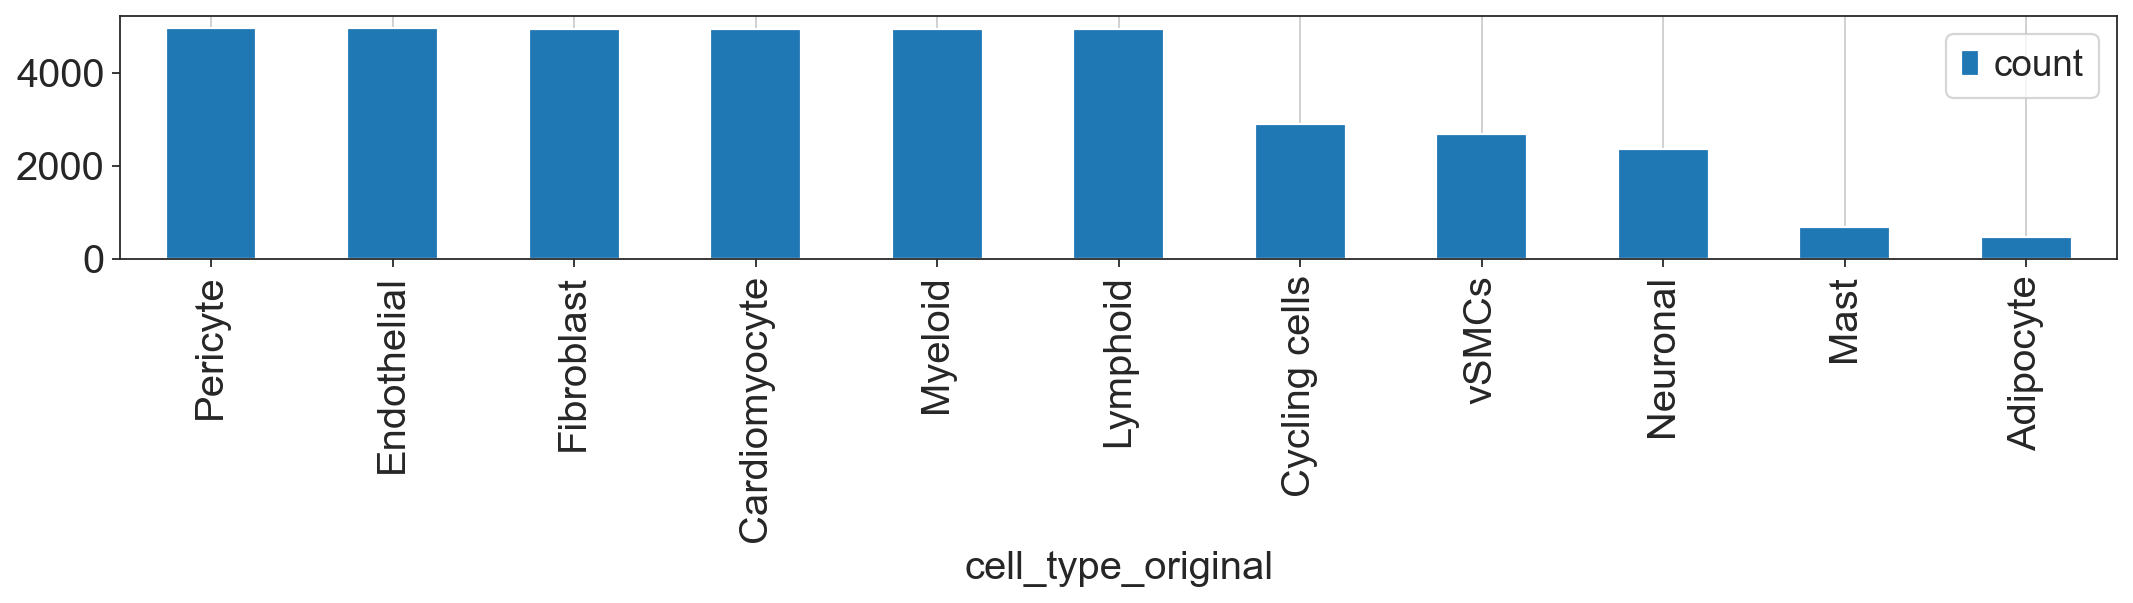

In [26]:
d= Counter(adata.obs[cluster_key])
print(len(d))

df = convert2df(d, cluster_key, "count")
#plt.figure(figsize=(45, 15))
ax = df.sort_values(by="count", ascending=False).plot.bar(x=cluster_key, y='count', rot=90, figsize=(16,2))
ax.grid(axis='x')

5


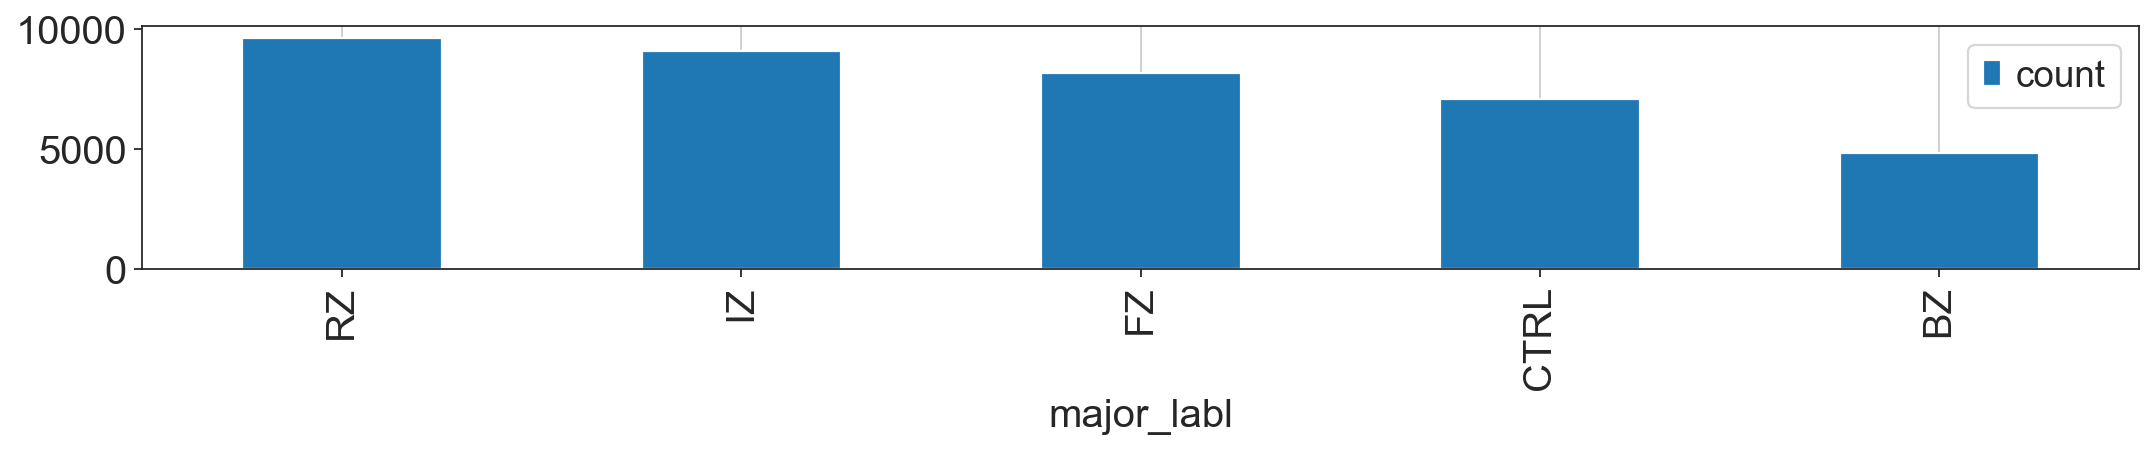

In [24]:
d= Counter(adata.obs["major_labl"])
print(len(d))

df = convert2df(d, "major_labl", "count")
#plt.figure(figsize=(45, 15))
ax = df.sort_values(by="count", ascending=False).plot.bar(x="major_labl", y='count', rot=90, figsize=(16,2))
ax.grid(axis='x')

29


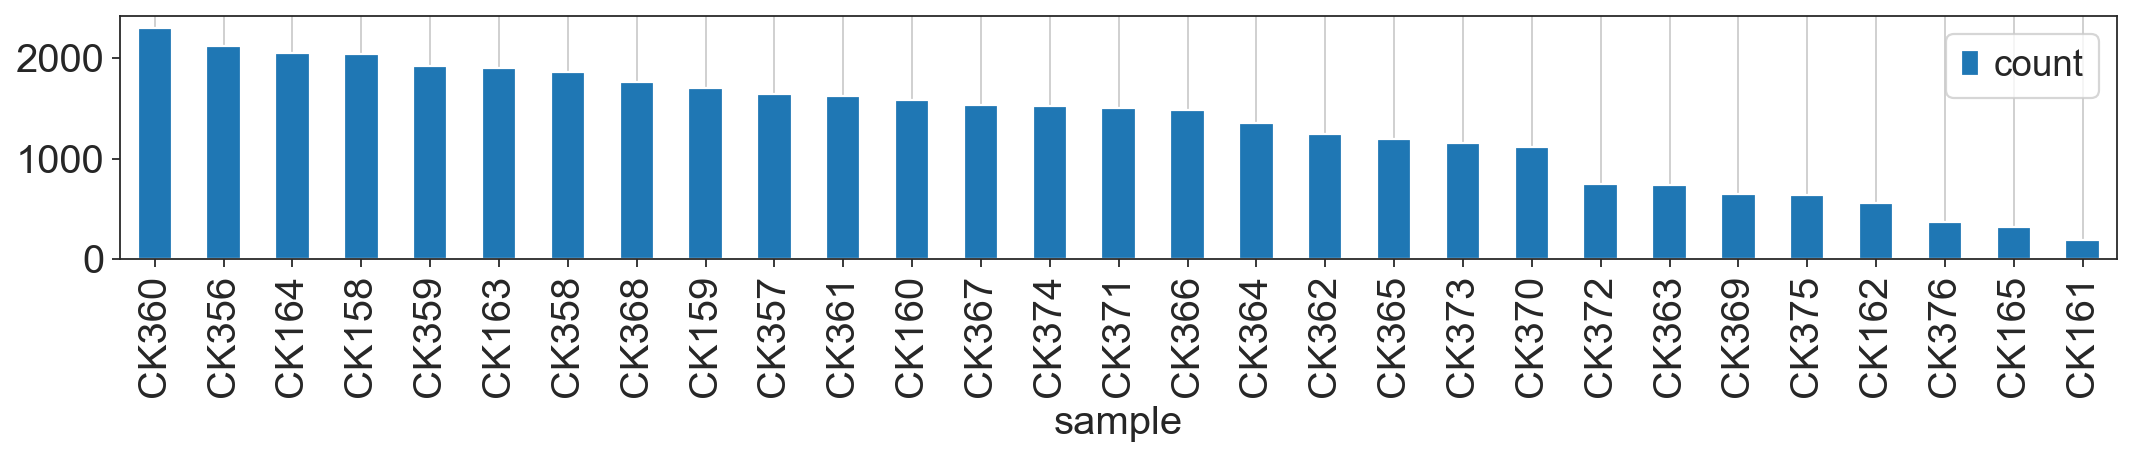

In [22]:
d= Counter(adata.obs["sample"])
print(len(d))

df = convert2df(d, "sample", "count")
#plt.figure(figsize=(45, 15))
ax = df.sort_values(by="count", ascending=False).plot.bar(x="sample", y='count', rot=90, figsize=(16,2))
ax.grid(axis='x')

In [27]:
mykey = 'sample'

In [28]:
count_df = pd.crosstab(adata.obs[mykey], adata.obs[cluster_key])
mycount_adata = anndata.AnnData(X=count_df)
mycount_adata.obs[mykey] = mycount_adata.obs.index

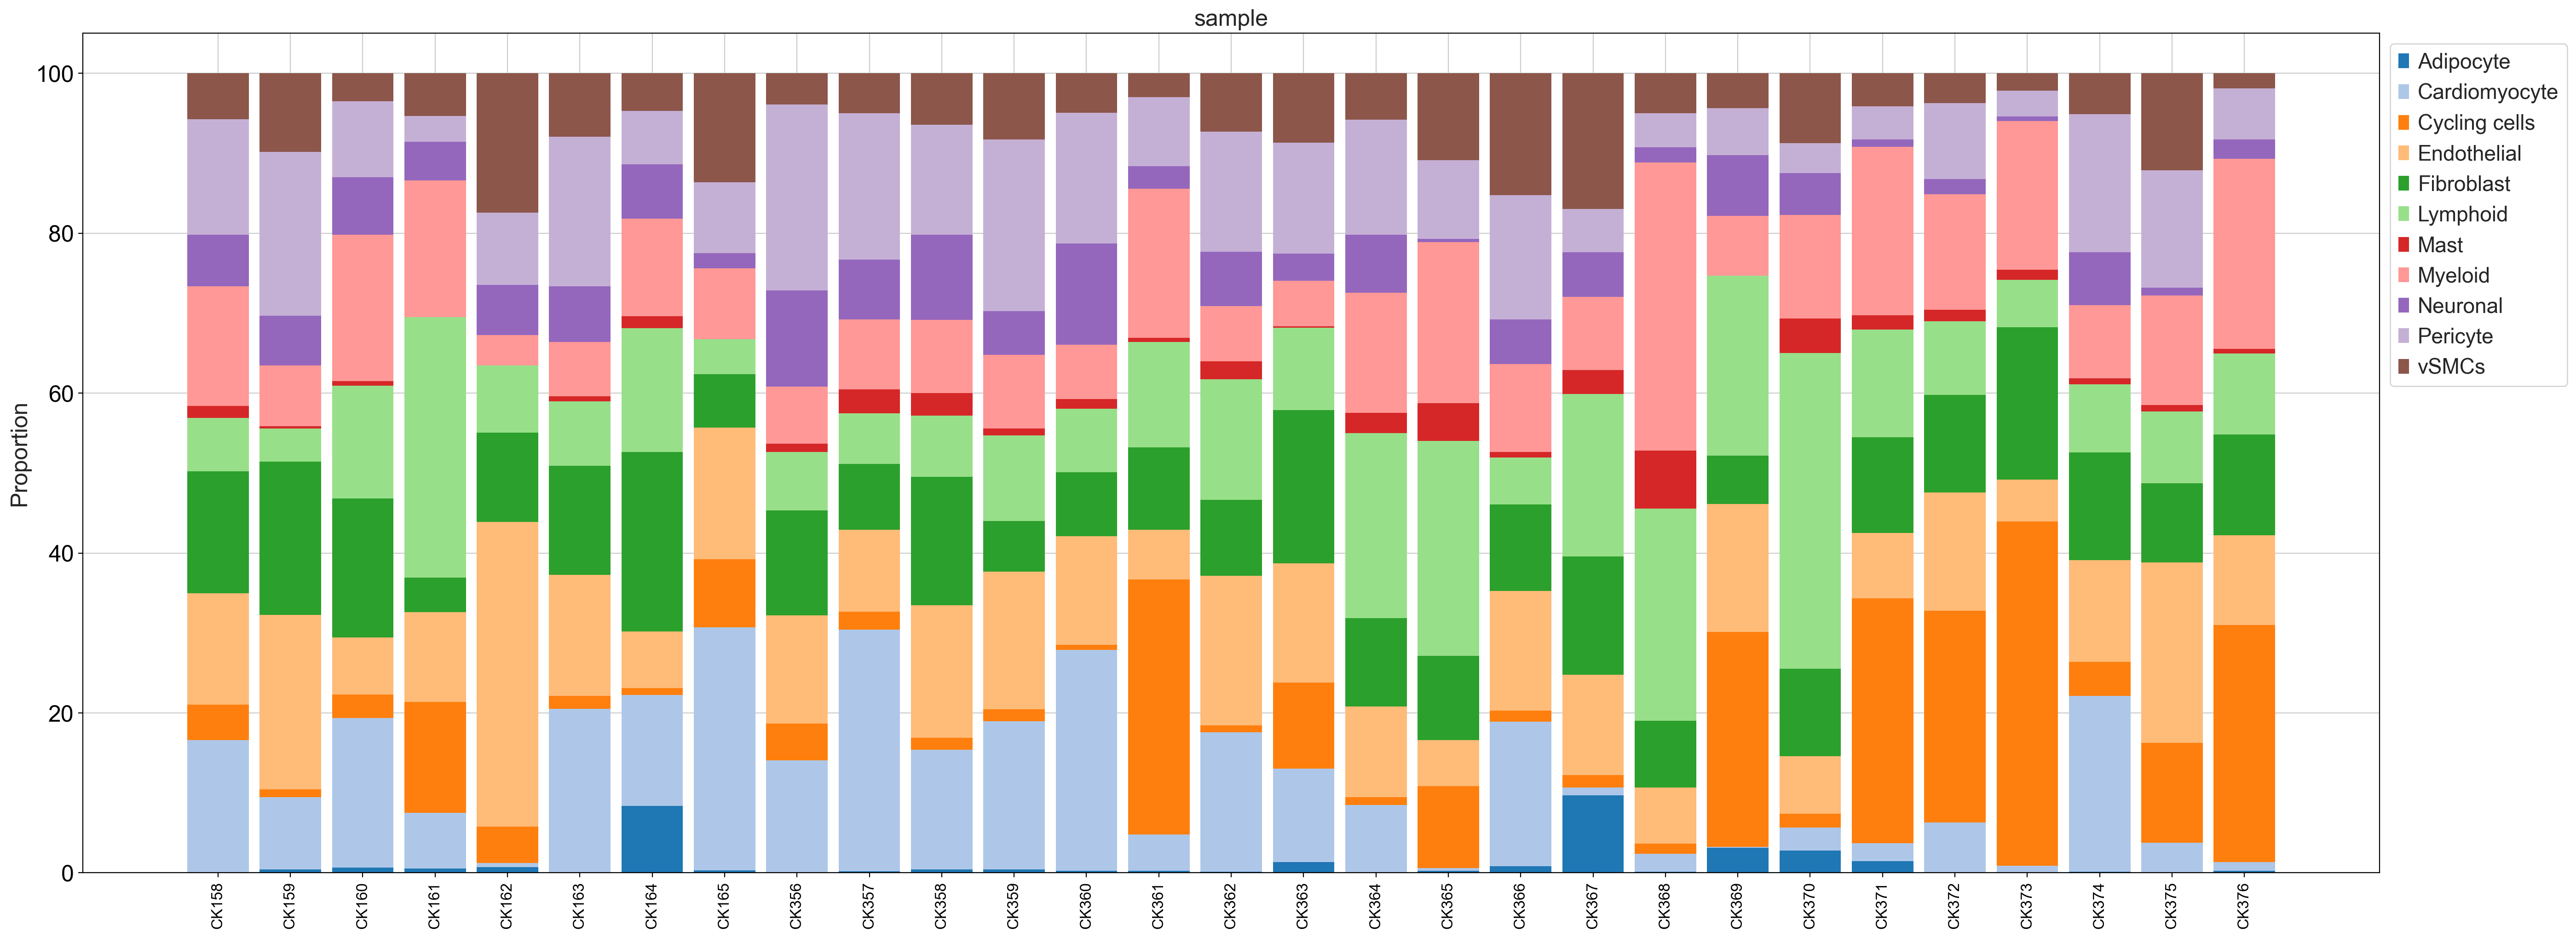

In [35]:
##visualization
with rc_context({'figure.figsize': (32, 12)}):
    viz.stacked_barplot(mycount_adata, feature_name=mykey)
    plt.xticks(fontsize=12, rotation=90)
    plt.show()

In [38]:
mykey = 'major_labl'

In [39]:
count_df = pd.crosstab(adata.obs[mykey], adata.obs[cluster_key])
mycount_adata = anndata.AnnData(X=count_df)
mycount_adata.obs[mykey] = mycount_adata.obs.index

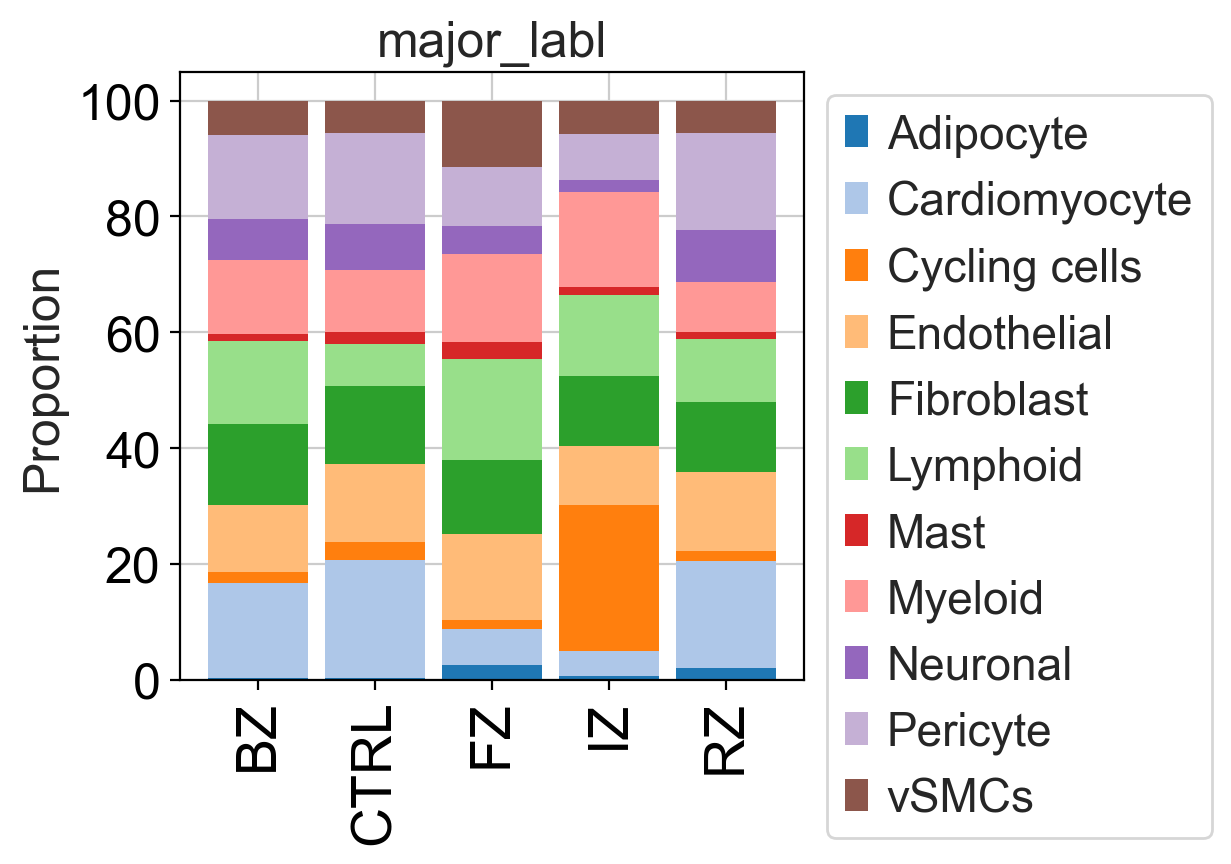

In [40]:
##visualization
viz.stacked_barplot(mycount_adata, feature_name=mykey)
plt.xticks(fontsize=20, rotation=90)
plt.show()

In [41]:
temp_la_df = adata.obs[["sample", cluster_key, mykey]]

In [42]:
temp_la_df[["sample", mykey]].drop_duplicates()

,sample,major_labl
ACACCAAGTGTCATGT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1-0,CK158,CTRL
ACCTGTCGTCTACAGT-1_2_1_1_1_1_1_1_1_1_1_1_1_1_1-0,CK159,FZ
AAAGTCCCATCATCTT-1_1_1_1_1_1_1_1_1_1_1_1_1_1-0,CK160,BZ
ACTGATGGTACCTAGT-1_2_1_1_1_1_1_1_1_1_1_1_1_1-0,CK161,IZ
AAAGGGCTCATAGCAC-1_1_1_1_1_1_1_1_1_1_1_1_1-0,CK162,FZ
CCTCAACGTACTCGTA-1_2_1_1_1_1_1_1_1_1_1_1_1-0,CK163,BZ
AACAAAGCAGAGAGGG-1_1_1_1_1_1_1_1_1_1_1_1-0,CK164,RZ
TTTACGTGTTGCGGCT-1_2_1_1_1_1_1_1_1_1_1_1-0,CK165,IZ
AGGTAGGCAGAGTGAC-1_1_1_1_1_1_1_1_1_1_1-0,CK356,RZ
GTAATCGAGCGATTCT-1_2_1_1_1_1_1_1_1_1_1-0,CK357,CTRL


In [43]:
Counter(adata.obs[mykey])

Counter({'CTRL': 7073, 'FZ': 8159, 'BZ': 4836, 'IZ': 9110, 'RZ': 9647})

In [44]:
la_df = temp_la_df.reset_index().groupby(["sample", cluster_key]).agg("count").reset_index()

In [45]:
la_df

,sample,cell_type_original,index,major_labl
0,CK158,Adipocyte,2,2
1,CK158,Cardiomyocyte,338,338
2,CK158,Cycling cells,90,90
3,CK158,Endothelial,286,286
4,CK158,Fibroblast,312,312
...,...,...,...,...
314,CK376,Mast,2,2
315,CK376,Myeloid,89,89
316,CK376,Neuronal,9,9
317,CK376,Pericyte,24,24


In [46]:
la_df = la_df[["index", "sample", cluster_key]].pivot(index=cluster_key,\
                                                           columns='sample', values='index').\
dropna(axis=1, how='all')

In [47]:
la_df.fillna(0, inplace=True)

In [48]:
myla_adata = anndata.AnnData(X=la_df.T)

In [49]:
myla_adata.obs["sample"] = myla_adata.obs.index

In [50]:
myla_adata

AnnData object with n_obs × n_vars = 29 × 11
    obs: 'sample'

In [51]:
Counter(adata.obs["major_labl"])

Counter({'CTRL': 7073, 'FZ': 8159, 'BZ': 4836, 'IZ': 9110, 'RZ': 9647})

In [52]:
print(temp_la_df[temp_la_df["major_labl"]=="CTRL"]["sample"].drop_duplicates().values.tolist())

['CK158', 'CK357', 'CK358', 'CK374']


In [53]:
print(temp_la_df[temp_la_df["major_labl"]=="FZ"]["sample"].drop_duplicates().values.tolist())

['CK159', 'CK162', 'CK366', 'CK367', 'CK368', 'CK370']


In [54]:
print(temp_la_df[temp_la_df["major_labl"]=="IZ"]["sample"].drop_duplicates().values.tolist())

['CK161', 'CK165', 'CK361', 'CK363', 'CK365', 'CK369', 'CK371', 'CK376', 'CK372', 'CK375', 'CK373']


In [55]:
print(temp_la_df[temp_la_df["major_labl"]=="RZ"]["sample"].drop_duplicates().values.tolist())

['CK164', 'CK356', 'CK359', 'CK360', 'CK362']


In [56]:
print(temp_la_df[temp_la_df["major_labl"]=="BZ"]["sample"].drop_duplicates().values.tolist())

['CK160', 'CK163', 'CK364']


In [57]:
myla_adata

AnnData object with n_obs × n_vars = 29 × 11
    obs: 'sample'

In [58]:
bz_samples   = ['CK160', 'CK163', 'CK364']
fz_samples   = ['CK159', 'CK162', 'CK366', 'CK367', 'CK368', 'CK370']
iz_samples   = ['CK161', 'CK165', 'CK361', 'CK363', 'CK365', 'CK369', 'CK371', 'CK376', 'CK372', 'CK375', 'CK373']
rz_samples   = ['CK164', 'CK356', 'CK359', 'CK360', 'CK362']
ctrl_sampls  = ['CK158', 'CK357', 'CK358', 'CK374']

def get_age_group(s):
    if s in bz_samples:
        return 'BZ'
    elif s in ctrl_sampls:
        return 'control'
    elif s in fz_samples:
        return 'FZ'
    elif s in iz_samples:
        return 'IZ'
    elif s in rz_samples:
        return 'RZ'
    else:
        raise ValueError(f'sample {s} not in definitions')

myla_adata.obs['mytreatment'] = myla_adata.obs['sample'].apply(get_age_group).astype('category')

In [59]:
myla_adata.obs.head()

,sample,mytreatment
sample,,
CK158,CK158,control
CK159,CK159,FZ
CK160,CK160,BZ
CK161,CK161,IZ
CK162,CK162,FZ


In [60]:
myla_adata

AnnData object with n_obs × n_vars = 29 × 11
    obs: 'sample', 'mytreatment'

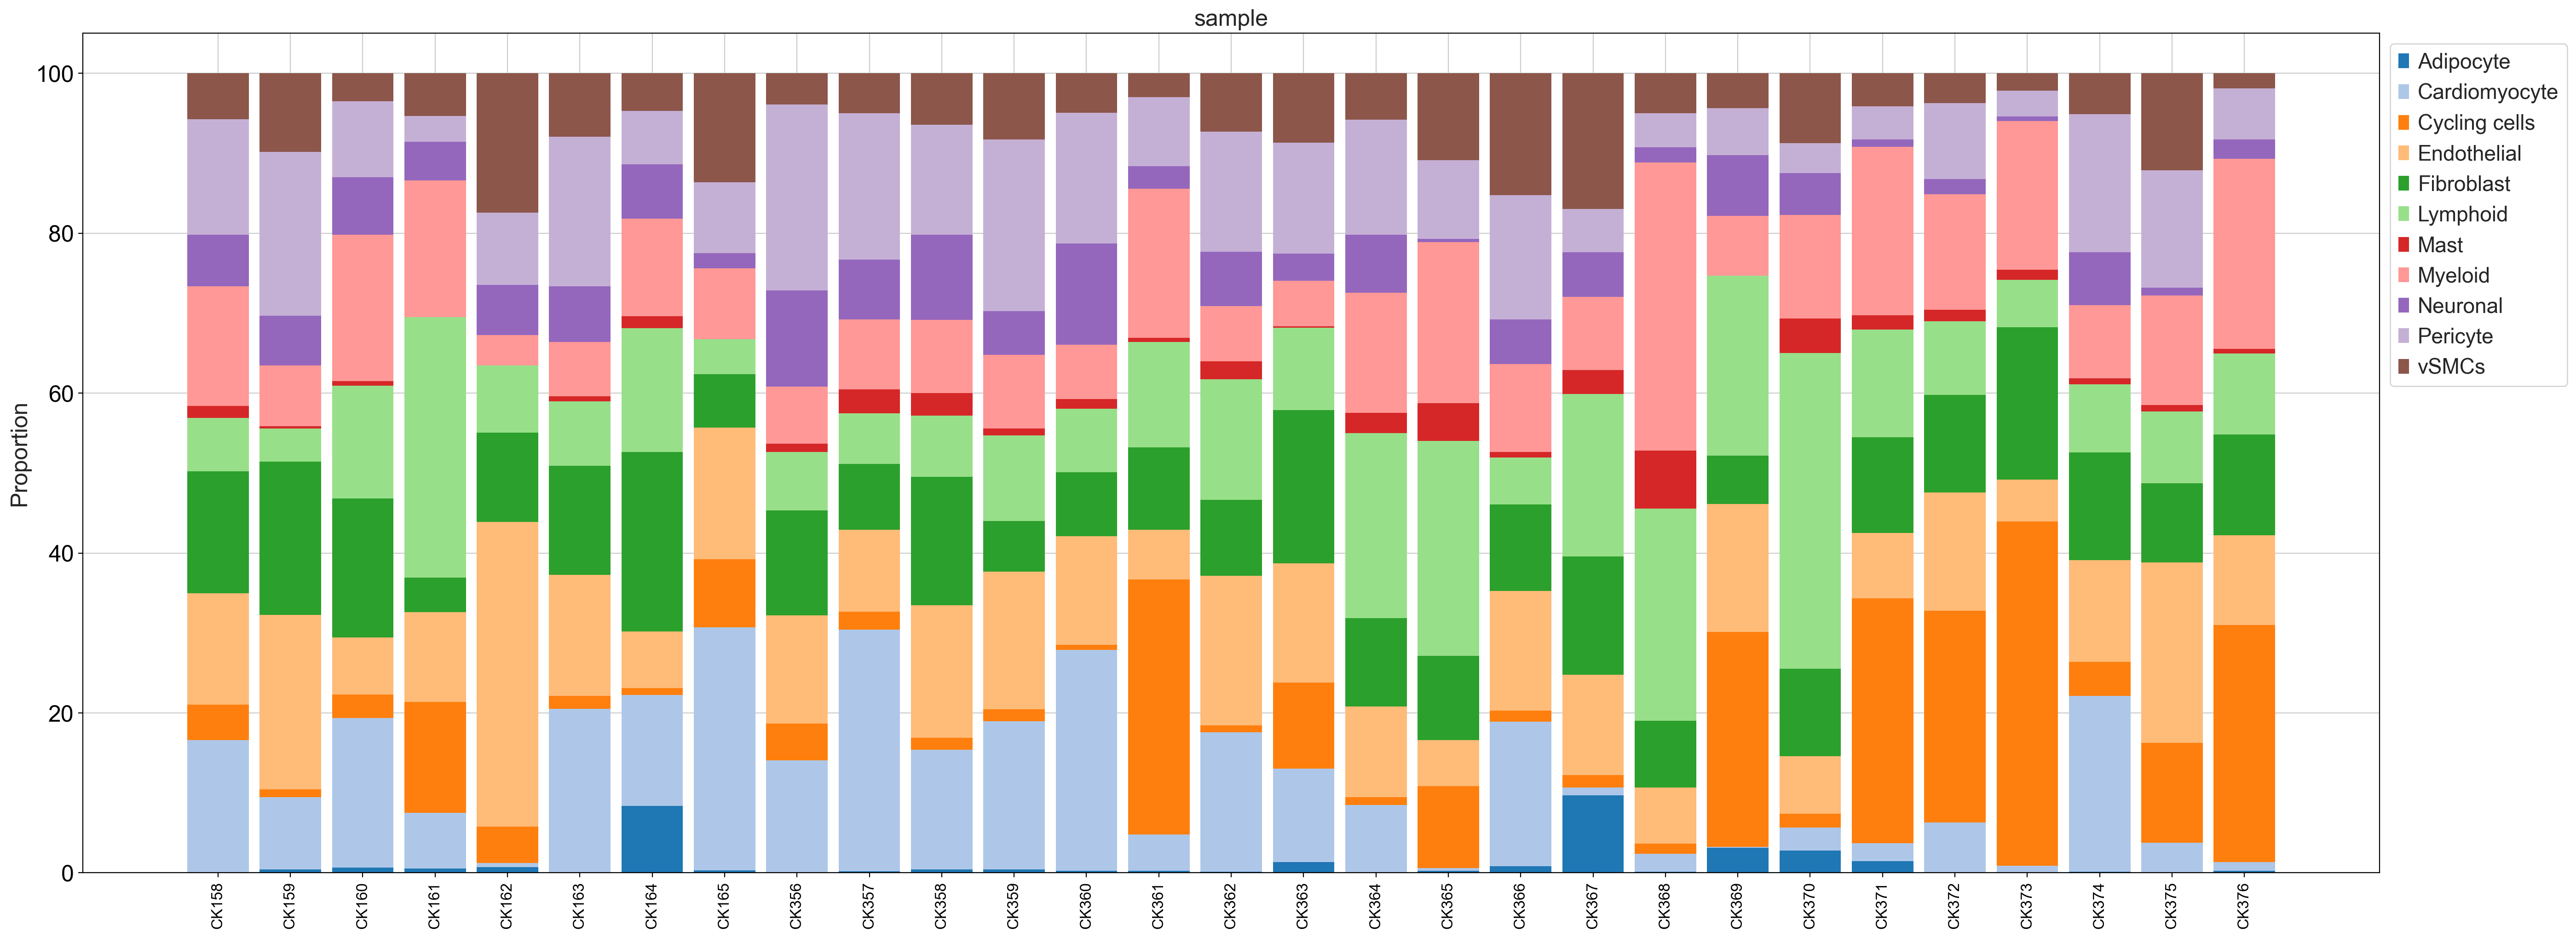

In [64]:
##visualization
with rc_context({'figure.figsize': (32, 12)}):
    viz.stacked_barplot(myla_adata, feature_name='sample')
    plt.xticks(fontsize=12, rotation=90)
    plt.show()

In [65]:
myla_adata.obs

,sample,mytreatment
sample,,
CK158,CK158,control
CK159,CK159,FZ
CK160,CK160,BZ
CK161,CK161,IZ
CK162,CK162,FZ
CK163,CK163,BZ
CK164,CK164,RZ
CK165,CK165,IZ
CK356,CK356,RZ


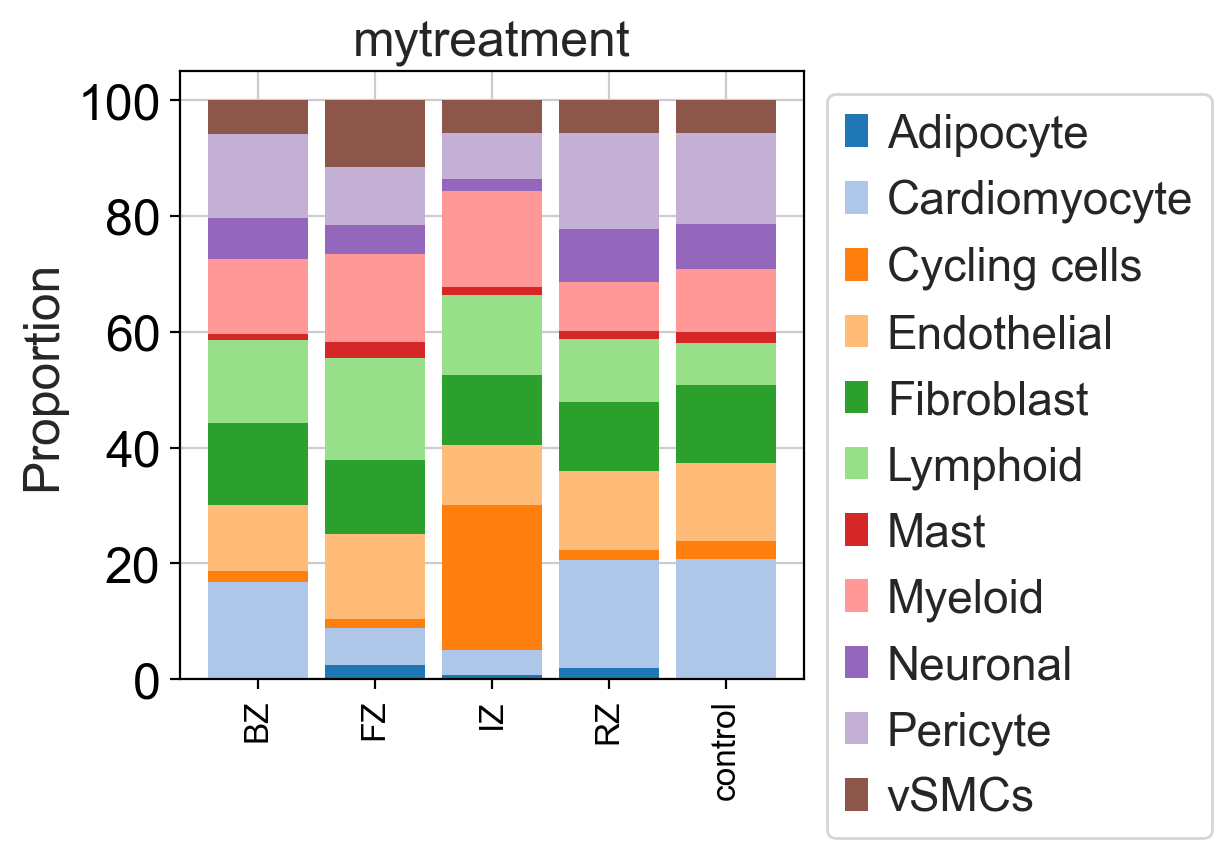

In [66]:
##visualization
viz.stacked_barplot(myla_adata, feature_name="mytreatment")
plt.xticks(fontsize=12, rotation=90)
plt.show()

In [67]:
# Function to select the reference group
# From: https://arxiv.org/pdf/1904.08937.pdf
def ref_group_sd(adata):
    '''
    adata = the anndata object generated as input for scCODA
            adata.X has the counts for each cell type (row) 
            for each sample (column).
            adata.var has the cell types
            adata.obs has the samples
    '''
    tocat = []
    # for each cell type in your adata object
    for j in adata.var.index:
        SD = []
        # for each cell type that is not your target cell type
        for k in [x for x in adata.var.index if x!=j]:
            # Take the sample standard deviation of this log10(ratio of j/k) across samples
            SD_jk = np.std(np.array(np.log10(((adata[:,adata.var.index == j].X) + 1)/
                                             ((adata[:,adata.var.index == k].X) + 1))), ddof=1)
            SD.append(SD_jk)
        # take the median of these SDs across every pair of cell types (j, k)
        S_j = np.median(SD)
        out = pd.DataFrame([j, S_j]).transpose()
        out.columns = ['celltype', 'S_j']
        tocat.append(out)
    
    S_all = pd.concat(tocat)
    
    return(S_all)

In [68]:
mysd = ref_group_sd(myla_adata)

In [69]:
mysd.sort_values(by="S_j")

,celltype,S_j
0,Fibroblast,0.372927
0,Endothelial,0.384928
0,Myeloid,0.406265
0,vSMCs,0.411512
0,Lymphoid,0.430391
0,Pericyte,0.434239
0,Neuronal,0.489026
0,Mast,0.540314
0,Adipocyte,0.625792
0,Cardiomyocyte,0.656384


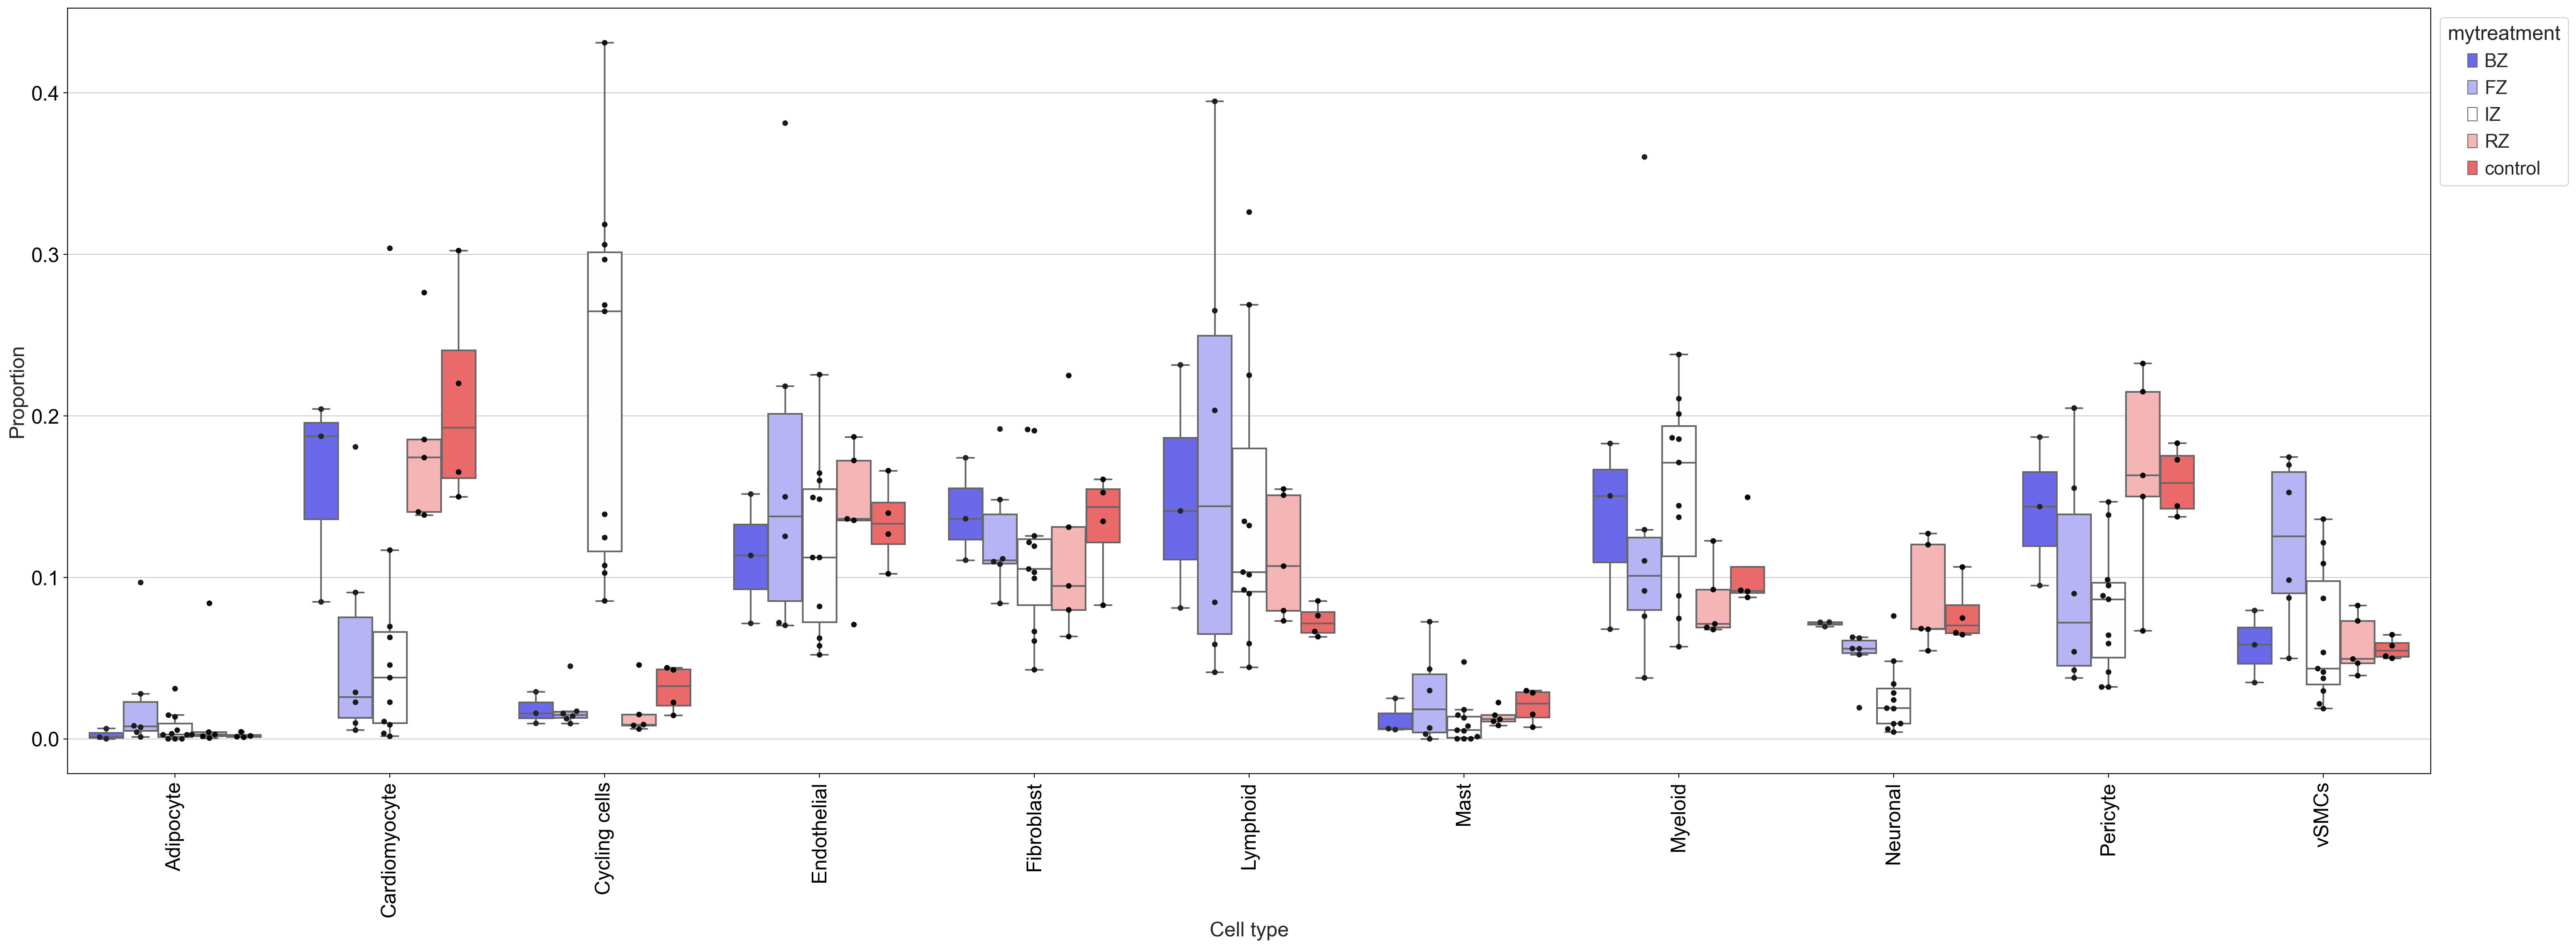

In [70]:
with rc_context({'figure.figsize': (32, 12)}):

    # Grouped boxplots. No facets, relative abundance, no dots.
    viz.boxplots(
        myla_adata,
        feature_name="mytreatment",
        plot_facets=False,
        y_scale="relative",
        add_dots=True,cmap="bwr",
    )
    plt.show()

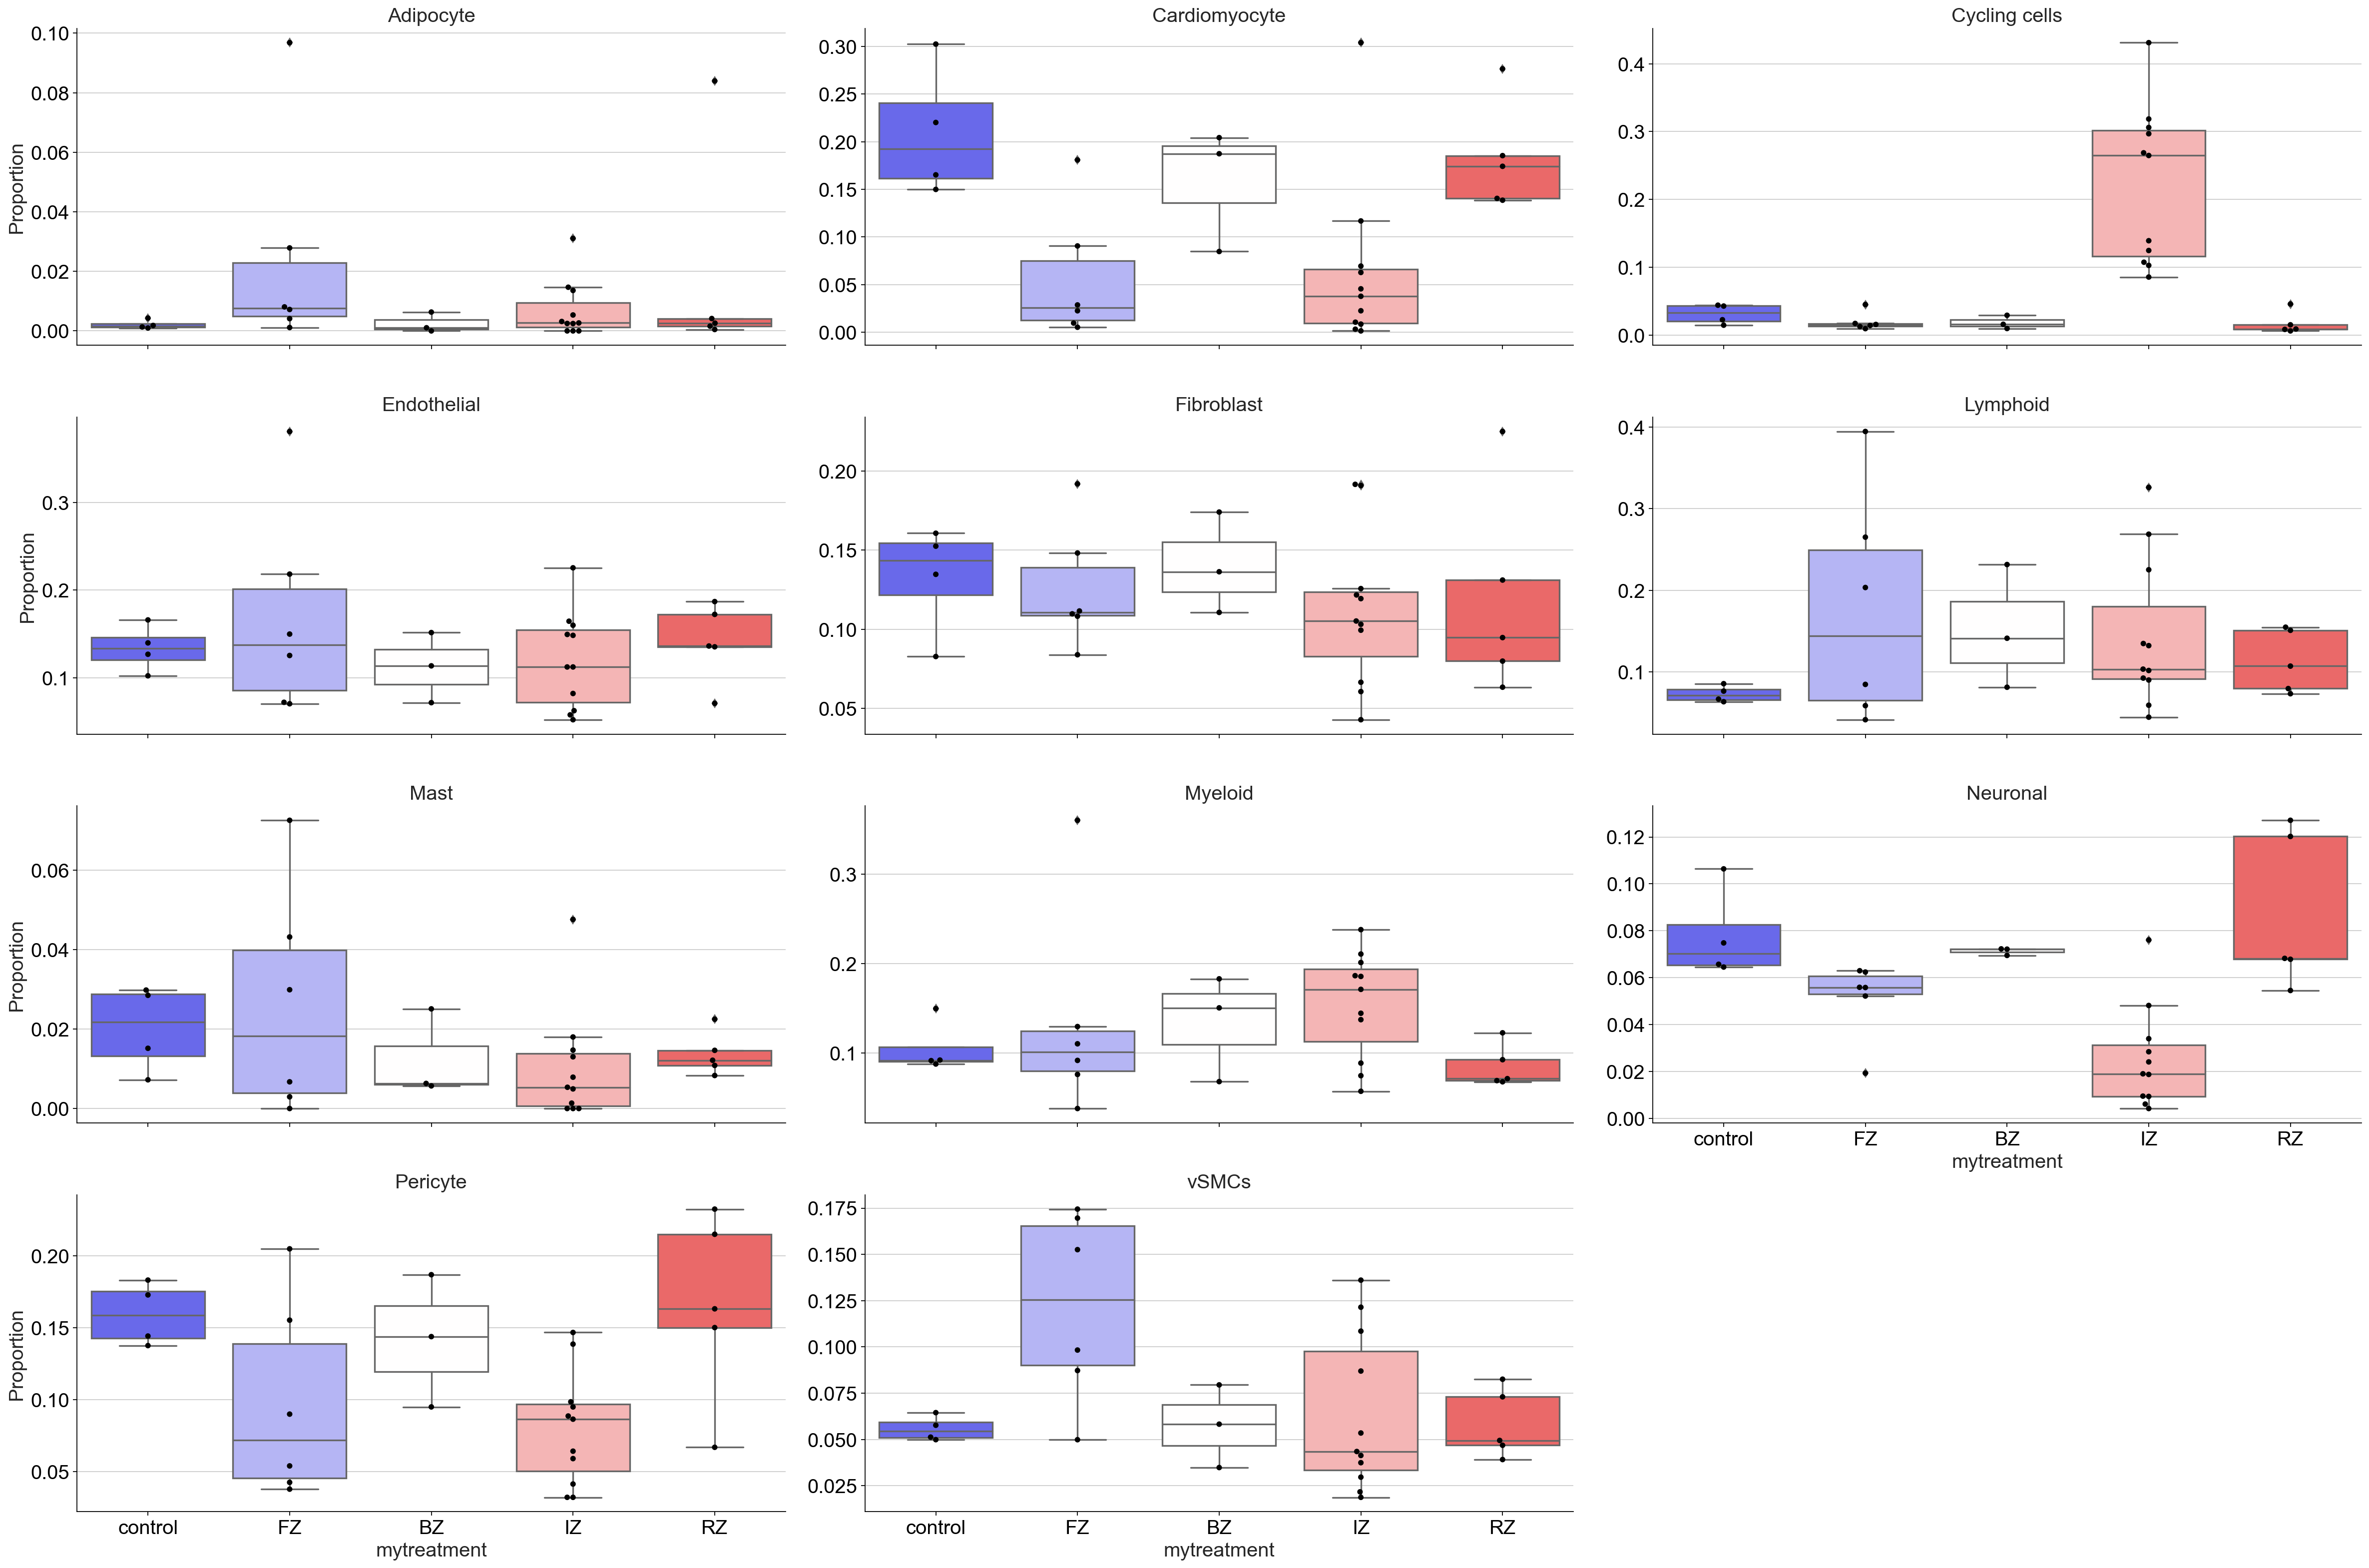

In [71]:
with rc_context({'figure.figsize': (32, 12)}):

    # Grouped boxplots. No facets, relative abundance, no dots.
    viz.boxplots(
        myla_adata,
        feature_name="mytreatment",
        plot_facets=True,
        y_scale="relative",
        add_dots=True,cmap="bwr",
    )
    plt.show()